# Entropy rates of programming languages

The aim of this project was to estimate information entropy rates across programming languagues. Entropy rate estimation is a well-known research problem in computational linguistics: it was first posed by Shannon himself in his 1951 paper ["Prediction and Entropy of Printend English"](http://languagelog.ldc.upenn.edu/myl/Shannon1950.pdf), which estabilished that entropy rate average English corpus is approximately 1 bit per character. Similar estimates were later computed for other natural languagues. (For a modern review of this problem, see [Takahira et al., 2016, "Entropy Rate Estimates for Natural Language—A New Extrapolation of Compressed Large-Scale Corpora"](http://www.mdpi.com/1099-4300/18/10/364).) No research know to me, however, concerned the topic of entropy estimation for programming languages.

In this study, I compare entropy rates of Python, JavaScript and C++ using Kaggle's [GitHub Repos](https://www.kaggle.com/github/github-repos) dataset. I sample 10000 files of Python, JavaScript, and C++ code and train *n*-th order Markov models (better known as character-level *n*-gram language models in NLP community) with $n \in [0, 5]$ range. Then, I compute their entropy rates and investigate their asymptotic behavior.

## What is entropy rate

Let us begin entropy, a measure of predictability of a dataset. Let $X$ be character sampled from some text; it can be any character from a distribution over an alpabet $A$ Then, its entropy $H(x)$ is expressed by the following equation:

$$H(X) = \sum_{x \in A} P(X=x) \log_2 (P(X = x))$$

Intuitively, the distribution over an alpabet $A$ does depened on characters preceding $X$. This can be captured with the notion of conditional entropy $H(X|Y)$, where $Y$ is a character just before $X$:

$$H(X|Y) = \sum_{y \in A} \sum_{x \in A} P(Y=y, X=X) \log_2 (P(Y=y, X = x))$$

Finally, entropy rate is entropy conditioned on a context of infinitely many preceding characers.

$$h(X_n) = \lim_{n \to \infty} H(X_n | X_1, ..., X_{n-1})$$

As mentioned above, we deal with this infinite limit with a rather crude esimate of $n \in [0, 5]$.

In [30]:
from collections import defaultdict, deque, Counter
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline
client = bigquery.Client()

In [2]:
def get_files(language_extension):
    QUERY = ('''
    SELECT SPLIT(content, '\\n') AS line
    FROM `bigquery-public-data.github_repos.sample_contents`
    WHERE sample_path LIKE "%.{ext}"
    
    '''.format(ext=language_extension))
    query_job = client.query(QUERY)
    bigquery_iterator = iter(query_job.result(timeout=120))
    return bigquery_iterator

## An example data entry

In [ ]:
bigquery_iterator = get_files('py')
next(bigquery_iterator)[0] 

In [3]:
class MarkovModel(object):
    def __init__(self, n):
        self.n = n
        self.model = defaultdict(Counter)
        self.freqs = Counter()
        self.buffer = deque(maxlen=self.n)
    
    def fit(self, stream):
        for token in stream:
            prefix = tuple(self.buffer)
            self.buffer.append(token)
            if len(prefix) == self.n:
                self.freqs[prefix] += 1
                self.model[prefix][token] += 1
    
    def entropy(self, prefix):
        prefix_freqs = self.model[prefix].values()
        normalization_factor = self.freqs[prefix]
        return -np.sum(f/normalization_factor * np.log2(f/normalization_factor) 
                       for f in prefix_freqs)
                
    def entropy_rate(self):
        normalization_factor = sum(self.freqs.values())
        unnormalized_rate = np.sum(self.freqs[prefix] * self.entropy(prefix) for prefix in self.freqs)
        try:
            return unnormalized_rate/normalization_factor
        except ZeroDivisionError:
            return 0

In [4]:
def tokenizer(text):
    return text  # char-level tokens

def iterator(bigquery_iterator, items=10000):
    counter = 0
    while(counter < items):
        counter += 1
        file = next(bigquery_iterator)[0]
        for line in file:
            if line == '':
                continue
            for token in tokenizer(line.lower().strip()):
                yield token

In [5]:
%%time
py_files = list(iterator(get_files('py')))
cpp_files = list(iterator(get_files('cpp')))
js_files = list(iterator(get_files('js')))

rates = pd.DataFrame(columns=['n', 'language', 'entropy_rate'])
for language, it in [('py', py_files), ('js', js_files), ('cpp', cpp_files)]:
    for n in range(5):
        model = MarkovModel(n=n)
        model.fit(stream=it)
        rate = model.entropy_rate()
        print(n, language, rate)
        rates.loc[len(rates)] = [n, language, rate]

0 py 4.85343788314
1 py 3.42627782595
2 py 1.56926853107
3 py 0.628065555869
4 py 0.411497460888
0 js 0
1 js 0
2 js 0
3 js 0
4 js 0
0 cpp 5.07501077029
1 cpp 3.54589824139
2 cpp 1.99413694559
3 cpp 1.01406367854
4 cpp 0.594331659513
CPU times: user 1.22 s, sys: 280 ms, total: 1.5 s
Wall time: 17.4 s


In [6]:
rates

,n,language,entropy_rate
0,0,py,4.853438
1,1,py,3.426278
2,2,py,1.569269
3,3,py,0.628066
4,4,py,0.411497
5,0,js,0.000000
6,1,js,0.000000
7,2,js,0.000000
8,3,js,0.000000
9,4,js,0.000000


# Conclusions

Below are entropy rates for our three languages plotted against Markov model orders. I also fitted 2nd degree polynomials (plotted with confidence intervals) to show the trend as *n* approaches infinity. We can conclude that entropy rates converge to 1.

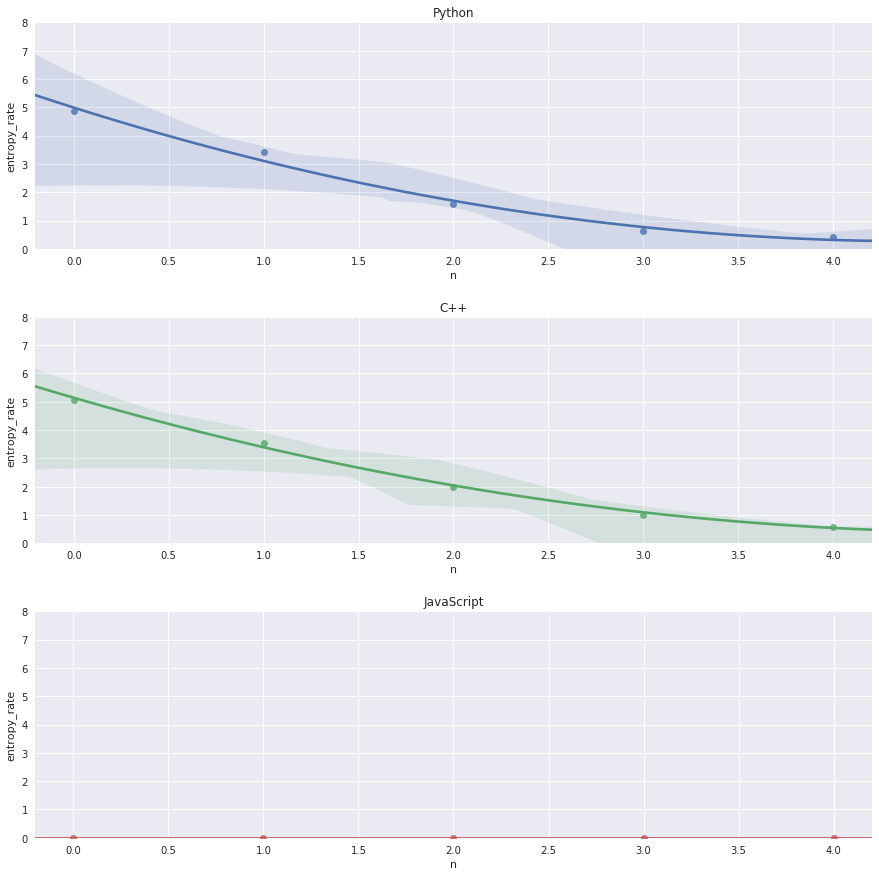

In [67]:
rates.n = np.float32(rates.n)
f, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, figsize=(15,15))
ax1.set_ylim(0, 8)
sns.regplot(x='n', y='entropy_rate', data=rates[rates.language=='py'], ax=ax1, order=2).set_title("Python")
sns.regplot(x='n', y='entropy_rate', data=rates[rates.language=='cpp'], ax=ax2, order=2).set_title("C++")
sns.regplot(x='n', y='entropy_rate', data=rates[rates.language=='js'], ax=ax3, order=2).set_title("JavaScript")
plt.subplots_adjust(hspace=0.3)
